<a href="https://colab.research.google.com/github/MikkonenTS/Futurice-Joda/blob/main/FuturiceJODA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

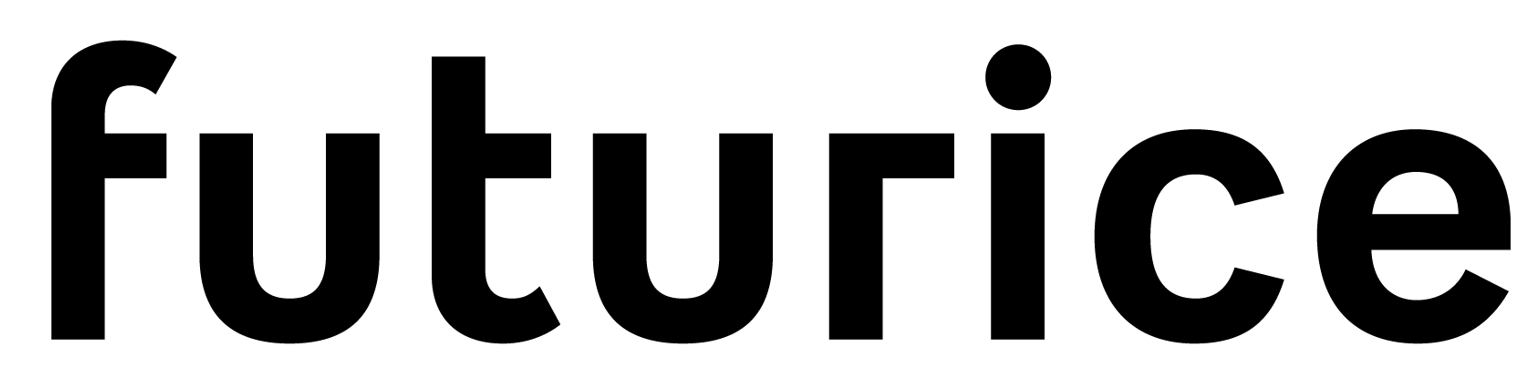

# Futurice NLP - Johdatus datatieteisiin
Vierailuluento 6.4.2021

In [ ]:
!pip install awscli
"AWScli asennettu"

## Mitä NLP on?

- Yksi datatieteiden erityisala, jossa datalähteenä on luonnollinen kieli
- Luonnollinen kieli on luonteeltaan rakenteetonta, joka asettaa datatieteiden näkökulmasta haasteita siinä, miten sitä voidaan käyttää datalähteenä.
- Olennaista on tekstin esikäsittely ja piirteiden erottaminen, jotka tähtäävät tietynlaiseen rakenteen luomiseen ja tekstin muuntamiseen laskettavaan, numeraaliseen muotoon.
<br>

- Yleisiä NLP:n käyttökohteita ovat mm. chatbotit, automaattiset konekäännökset, tekstin luokittelu ja tekstimassojen (korpus) analysointi
- NLP ei usein ole vain yksin käytetty käyttötapaus, vaan se usein linkittyy johonkin muuhun data/koneoppimisratkaisuun. NLP:n avulla voidaan esimerkiksi tehdä piirteiden eroitus, jolloin saadaan opetusdataan yksi ulottuvuus lisää.

## Google Colaboratory

- Googlen ylläpitämä ilmainen Notebook-palvelu
- Helppo jakaa koodia ja työskennellä yhdessä mm. dataprojekteissa.
- Saatavilla myös laskentatehoa (GPU & TPU -prosessointi)
  >- Yläpalkki
  >- Runtime
  >- Change runtime type
  >- Hardware accelerator
  >- GPU 

- Tähän harjoitukseen ei kuitenkaan tarvita lisälaskentatehoa (fastText-työkalu on CPU-pohjainen)
- HUOM. Saatavat laskentaresurssit riippuvat vapaana olevasta kapasiteetista, laskentateho ei näin ollen ole vakio. 

#### Hyödyllisiä pikakomentoja
> - ctrl/cmd + enter = suorita solu
> - shift + enter = suorita solu ja siirry seuraavaan
> - ctrl/cmd + m + b = luo solu alapuolelle
> - ctrl/cmd + m + b = luo solu yläpuolelle
> - ctrl/cmd + d + d = poista solut



# Eduskuntadatan luokittelu - ministerien vastaukset kirjallisiin kysymyksiin

- Luokitteluongelma -> Osoita tekstille mallin avulla sitä vastaava luokka

Data haettu repostoriosta https://github.com/aajanki/eduskunta-vkk (Antti Aajanki, Futurice)

Tähän esimerkkiin tarvittava data, sekä listaus tarvittavista Python-kirjastoista ladataan AWS S3-palvelusta

In [ ]:
#Haetaan pakettidata ja hukkasanalista avoimesta AWS S3-bucketista
!aws s3 --no-sign-request cp s3://nlpluentomateriaalit/requirements.txt requirements.txt
!aws s3 --no-sign-request cp s3://nlpluentomateriaalit/stopwords.txt stopwords.txt

In [ ]:

#Asennetaan tarvittavat kirjastot haetun requirements-tiedoston perusteella
!pip install -r requirements.txt

#Asennetaan voikko-kirjasto suoraan versionhallinnasta
!sudo apt -y install -y voikko-fi python-libvoikko

Imporit ja hukkasanalistan käsittely

In [ ]:
import pandas as pd
import numpy as np
import libvoikko #perusmutoistamiseen käytetty kirjasto
import fasttext as ft #Mallin opetuskseen käytettävä kirjasto
#import nltk #Natural Language Toolkit, hyödyllisiä NLP-perustyökaluja
import re #Regex
"Paketit importattu"

v = libvoikko.Voikko(u"fi")

with open('stopwords.txt', 'r', encoding='utf8') as sw:
    stopwords = sw.readlines()
    sw.close()

stopwords = [i.split("\n")[0] for i in stopwords]

### Stopwordit / Hukkasanat
- Sanoja jotka eivät lisää tekstikorpuksen informaatioarvoa
- NLP-datan "kohinaa"
- Prepositioita, partikkeleita yms.
- Tässä esimerkissä myös suomen kielen yleisimpiä erisnimiä
- Voidaan tehdä toimialakohtaisesti
  - Jonkun alan hukkasana voi olla tärkeä toisella alalla
  - Esimerkki? 

In [ ]:
print(stopwords[100:110])

---
# Datan lukeminen




Luetaan data edellämainitusta S3-bucketista ja puretaan bzip2-pakatut tiedostot. Data on jo valmiiksi jaettu opetus- ja testijoukkoon.

In [ ]:
!mkdir data
!aws s3 --no-sign-request cp s3://nlpluentomateriaalit/train.csv.bz2 data/train.csv.bz2
!aws s3 --no-sign-request cp s3://nlpluentomateriaalit/test.csv.bz2 data/test.csv.bz2
!bzip2 -d "data/train.csv.bz2"
!bzip2 -d "data/test.csv.bz2"

Luetaan data csv-tiedostosta Pandas DataFrameen

In [ ]:
df_train = pd.read_csv('data/train.csv').drop_duplicates()
df_test = pd.read_csv('data/test.csv').drop_duplicates()

### Analyysi

Tutustutaan hieman tarkemmin dataan, jota tässä esimerkissä käytetään. Pandas dataframen .head()-funktio näyttää jokaisen sarakkeen viisi ensimmäistä riviä, ja .info() näyttää sarakkeiden tietotyypit ja rivimäärän.

In [ ]:
df_train.head()

In [ ]:
df_train.info()

### Opetusdata ja labelit

Varsinaiseen opetusdataan on syytä pureutua tarkemmin, sillä opetuksen kannalta on merkittävää, kuinka paljon kullekin luokalle on opetusdatassa rivejä. Mikäli ero on merkittävä, se voi aiheuttaa opetuksen painottumista niihin tunnisteisiin, joille on eniten opetusdataa. 



In [ ]:
#Opetusdatan luokkien jakauma
df_train["ministry"].value_counts()

In [ ]:
df_train["ministry"].value_counts().sort_values(ascending=True).plot(kind = 'barh')

Huom. Kuten jakaumasta nähdää, ministerit eivät täysin vastaa niitä salkkuja, joita tällä hetkellä on, koska salkkujen sisältö on myös muuttunut vuosien varrella. Datasetin kehittäjä on yhdistellyt historiadatassa esiintyviä salkkuja, että jakauma pysyy miellyttävänä

#### Mitä tälle voidaan tehdä? 
Tämän vuoksi datasettejä on joskus tarpeen tasapainottaa joko yliotannan tai aliotannan menetelmin. Yliotannassa datasettiin voidaan luoda keinotekoisia arvoja, jotka ovat lähellä kyseisen tunnisteen datapisteitä. Aliotannassa karsitaan yleisimpien luokkien datapisteiden määrää, jotta luokkien datapisteet ovat jakautuvat tasaisemmin.



---


# Esikäsittely

Esikäsittely on tärkeä vaihe missä vain koneoppimisprosessissa. Sen tarkoitus on:
- Parantaa opetusdatan laatua
- Vähentää kohinaa (dataa, joka vaikeuttaa piirteiden erottamista opetusdatasta)
- Muuntaa opetusdata muotoon, jossa sitä voidaan käyttää mallin opetukseen

Tässä NLP-esimerkissä opetusdataa esikäsitellään sekä ennen mallin opettamista, että mallin opetusfunktion sisällä. Esikäsittely, jossa datan laatua parannetaan tehdään manuaalisesti. Varsinainen piirteiden erotus ja teksin muuttaminen numeromuotoon, tässä tapauksessa sanavektoreiksi, tapahtuu opetusfunktiossa. 



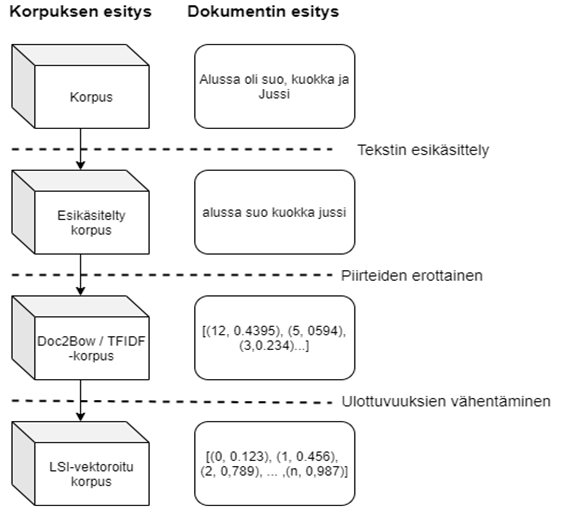

Data on muutettava fastText-mallin opetusta varten muotoon, jossa jokaisella rivillä opetustekstiä edeltää mallin luokka. Esim:
> \_\_label__valtionvarainministeri Lorem ispum dolor sit amet

Tämän jälkeen opetus- ja testidata kirjoitetaan levylle tiedostoksi. 

### Esikäsittely vaiheittain
 - Pienet alkukirjaimet
 - Erikoismerkkien poisto
 - Hukkasanojen poisto
 - Perusmuotoistaminen
 - (stemmaus)


In [ ]:
text = df_train["sentence"][6]
print("Alkuperäinen teksti: ", text)
text_l = text.lower()
print("Pienet alkukirjaimet: ", text_l)

Poistetaan seuraavaksi tekstistä erikoismerkit, kuten pisteet, pilkut, viivat, kautta-merkit yms.

HUOM! Mikäli tekstissä haluaa säilyttää lauserakenteen (jotkin mallit vaativat lauseittain opetusta, esim Gensim), on se otettava huomioon tässä vaiheessa, sillä pisteet häviävät regex-komennossa

In [ ]:
#Erikoismerkkien poisto:

words = text.split(" ") #Tehdään tekstin sanoista lista, jota voidaan esikäsitellä sana kerrallaan

preprocessed_words = [] #Tyhjä lista esikäsitellyille sanoille

for word in words:
  word = re.sub("[^A-Za-z0-9ÄäÖö-]+", "", word) #Poistetaan regexin avulla kaikki merkit paitsi A-Ö-kirjaimet ja numerot
  word = re.sub("-", " ", word) #Muutetaan regex-komennon avulla kaikki väliviivalliset sanat eri sanoiksi vaihtamalla viivan tilalle välilyönti
  word = word.strip().lower() #Poistetaan sanan ympäriltä ylimääräiset välilyönnit ja muutetaan kaikki kirjaimet pieniksi
  if len(word) > 2:  #Hylätään kaikki kaksi merkkiä lyhyemmät merkkijonot
    preprocessed_words.append(word) #Lisätään sana esikäsiteltyjen sanojen listaan

text_sc = " ".join(preprocessed_words) #Liitetään listan sanat toisiinsa välilyönnein
print("Alkuperäinen teksti: ", text)
print("Erikoismerkit poistettu:", text_sc)

Seuraavassa vaiheessa muunnetaan sanat perusmuotoon

In [ ]:
#Käytetään edellisen solun sanalistaa

baseform_words = []

for word in words:
  if type(word) != None: #Ohitetaan ns. tyhjät merkkijoukot
    voikko_dict = v.analyze(word)
    if voikko_dict:
      word = voikko_dict[0]['BASEFORM']
      if word not in stopwords:
        baseform_words.append(word)

text_bf = " ".join(baseform_words)
print("Alkuperäinen:", "\n", text, "\n")
print("Perusmuotoinen:", "\n", text_bf)


Seuraavassa solussa on edelliset vaiheet kirjoitettu funktioksi, joilla on helppo käsitellä koko tekstijoukko opetusta varten

In [ ]:
#TODO Muuta helpommin ymmärrettäväksi

def preprocess_word(word, stopwords):

    word = re.sub("[^A-Za-z0-9ÄäÖö-]+", "", word)
    word = re.sub("-", " ", word)
    word = word.strip().lower()
    if len(word) < 2:
      return ""
    if type(word) != None:
        voikko_dict = v.analyze(word)
        if not voikko_dict:
          return ""
        word = voikko_dict[0]['BASEFORM']
        if word in stopwords:
          return ""
        return word


def preprocess_sent(sent, stopwords):

    if sent != "":
        words = sent.strip().split(" ")
        final_sent = " ".join([preprocess_word(word, stopwords) for word in words if type(word) != None])
        return final_sent

def preprocess_row(teksti, stopwords):

    if type(teksti) == str:
        sents = teksti.strip().split(".")
        sents = filter(None,sents)
        teksti = ".".join([preprocess_sent(sent, stopwords) for sent in sents if type(sent) != None])
        return teksti

FastText-mallin opetus vaatii opetuslabelille tunnisteen, tässä tilanteessa käytetään oletusarvoa \_\_label__

In [ ]:
df = df_train[:10]

In [ ]:
df.loc[:,"label"] = ["__label__" + i for i in df.loc[:,"ministry"]]
df.head()

Käytetään apufunktiota luomaan uusi dataframeen uusi sarake "Preprocessed"

In [ ]:
df["preprocessed"] = [preprocess_row(sentence, stopwords) for sentence in df["sentence"]]
df.head()

In [ ]:
df["preprocessed"][4]

In [ ]:
df.head()

In [ ]:
#Apufunktio, jolla voidaan luoda fastText-yhteensopiva opetus- ja tekstitiedosto

def preprocess_ft_df(df):
  df["label"] = ["__label__" + "_".join(i.split(" ")) for i in df["ministry"]]
  df["preprocessed"] = [preprocess_row(sentence, stopwords) for sentence in df["sentence"]]
  df = df.drop(["ministry", "sentence"], axis = 1)
  return df

In [ ]:
df_train = preprocess_ft_df(df_train)
df_test = preprocess_ft_df(df_test)

In [ ]:
df_train.head()

In [ ]:
#df_train = df_train.drop(["ministry", "sentence"], axis = 1)
df_train.to_csv("data/train_ft.txt", sep='\t', index = False, header = False)
df_test.to_csv("data/test_ft.txt", sep='\t', index = False, header = False)

In [ ]:
df_test.head()

# Mallin opetus

FastText - Facebook research

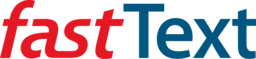

- FastText on NLP-kirjasto, jonka avulla voidaan käsitellä sanoja vektorimuodossa


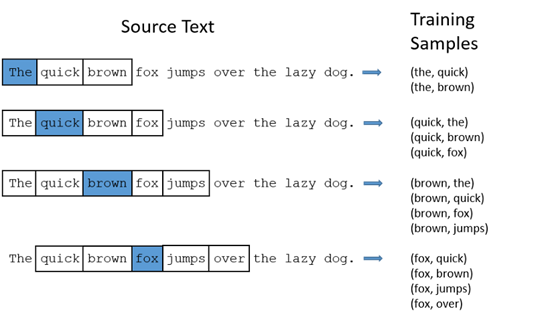

- Sanavektorit muodostetaan sanoille kontekstinsa perusteella
- Monia kirjastoja joilla voidaan tuottaa sanavektoreita, FastTextin etuna sanansisäisen informaation hyödyntäminen. 

In [ ]:
#@title Mallin opetusparametrit
#@markdown Input: Polku opetustiedostoon
input = "data/train_ft.txt"#@param {type:"string"}

#@markdown label_prefix: Luokan tunnuksen etuliite
label_prefix = "__label__"#@param {type:"string"}

#@markdown Epoch: Montako kertaa mallin opetus iteroidaan
epoch = 100#@param {type:"number"}

#@markdown Dim: Miten monta ulottuvuutta mallin opettamat sanavektorit sisältävät
dim = 100#@param {type:"number"}

#@markdown Word_ngrams: Minkäkokoisia ngrameja ympäröivistä sanoista muodostetaan
word_ngrams = 3#@param {type:"number"}

#@markdown ws: window size, miten monta ympäröivää sanaa tulkitaan sanan kontekstiksi
ws= 3#@param {type:"number"}


#Mallin opetus tapahtuu komennolla train_supervised ja malli tallennetaan muuttujaan
ft_classifier = ft.train_supervised(
                          input = input,
                          label_prefix = label_prefix,
                          epoch = epoch, 
                          dim = dim,
                          word_ngrams = word_ngrams,
                          ws = ws
                          )



In [ ]:
df_test

# Mallin testaus

In [ ]:
ft_classifier.test("data/test_ft.txt", 1)
#Taas tämä fasttextin "P@1 ja R@1", predictillä mielenkiintoisempia tuloksia

Ajatuskoe: mallin tarkkuus
Minkä takia ei ole suotavaa testata vain ja ainoastaan kuinka monta ennustetta meni oikein ja kuinka moni väärin

# Mallin soveltaminen

Haetaan ulkopuolinen datalähde ja testataan mallin soveltuvuutta. Tässä tapauksessa ministerien twiittejä

In [ ]:
ft_classifier.predict(preprocess_row("Keskustelemme myös metsäpolitiikasta. Suomen viesti on selvä; metsäpolitiikka kuuluu kansalliseen päätösvaltaan. Metsäpolitiikassa on huomioitava kokonaiskestävyys. Metsät ovat sekä että luonnonvara - hyödynnämme niitä sosiaalisesti, taloudellisesti ja ympäristön näkökulmasta.", stopwords), k=1)

In [ ]:
ft_classifier.predict(preprocess_row("Tein tänään virtuaalivierailun Porin prikaatin Niinisalon varuskuntaan. Sain esittelyn varuskunnan toiminnasta ja tilaisuuden keskustella henkilökunnan ja varusmiesten kanssa. Tämä taisi olla maamme historian ensimmäinen ministerin etävierailu varuskuntaan. Kannatti tehdä.", stopwords), k=1)

In [ ]:
ft_classifier.predict(preprocess_row("Arvokas näkemystenvaihto @antonioguterres kanssa Etiopian Tigrayn alueen humanitaarisesta kriisistä. Suomi ja EU vaativat avun esteetöntä pääsyä ja kansainvälisen oikeuden kunnioittamista. YK:lla ja kansainvälisillä järjestöillä on avainrooli avun saamisessa alueelle.", stopwords), k= 3) 

In [ ]:
def predict_text(text, preprocess = True):
  if preprocess:
    return ft_classifier.predict(preprocess_row(text, stopwords))
  else:
    return ft_classifier.predict(text)

In [ ]:
test_text =  """
            Tein tänään virtuaalivierailun Porin prikaatin Niinisalon varuskuntaan.
            Sain esittelyn varuskunnan toiminnasta ja tilaisuuden keskustella henkilökunnan ja varusmiesten kanssa.
            Tämä taisi olla maamme historian ensimmäinen ministerin etävierailu varuskuntaan. Kannatti tehdä.
            """

print("Ministeriö:", predict_text(test_text, True)[0][0], "\n", "Todennäköisyys:", round(predict_text(test_text, True)[1][0],3))

In [ ]:
tests = ["Hallitus esittää väliaikaisia lainmuutoksia rangaistusten täytäntöönpanoon ja tutkintavankeuden toimeenpanoon. Väliaikaisen lain tavoitteena on varmistaa vankiloiden turvallisuus koronavirusepidemian aikana.",
         "Harvennus- ja uudistushakkuut Evolla keskeytetään, vain monimuotoisuutta lisäävä polttoa valmisteleva hakkuu tehdään suunnitellusti. Oikea päätös @Metsahallitus . Tiedekansallispuistoa valmisteleva työryhmä saa työrauhan.",
          "Meidän on tuettava erityisesti henkilöitä, jotka ovat heikoimmassa asemassa työmarkkinoilla. Suomessa kehitetään parhaillaan mallia, joka edistäisi osatyökyisten työllistymistä”, kertoi työministeri @TuulaHaatainen  EU-kollegoilleen videokokouksessa."]
for i in tests:
  print("Ministeriö:", predict_text(i, True)[0][0], "\n", "Todennäköisyys:", round(predict_text(i, True)[1][0],3), "\n")

# Yhteenveto

Eli mitä tehtiin:

- Kirjastojen lataus ja asennus
- Datan lataus
- Datan esikäsittely
- Esikäsiteltyjen tiedostojen kirjoitus
- Mallin opettaminen
- Mallin testaus
- Mallin soveltaminen